In [1]:
library(tidyverse)
if (!require(data.table)) install.packages("data.table")
library(data.table)
install.packages("R.utils")
ws_namespace <- Sys.getenv('WORKSPACE_NAMESPACE')
ws_name <- Sys.getenv('WORKSPACE_NAME')
ws_bucket <- Sys.getenv('WORKSPACE_BUCKET')  # References workspace bucket ("gs://fc-secure-...")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Installing package into ‘/home/jupyter-user/notebooks/packages’
(as ‘lib’ is unspecified)



In [2]:
options(repr.plot.width = 10, repr.plot.height = 6)

# Import and read in files 

## COVID-19 phenotypes

In [3]:
# system(paste0("gsutil cp ", ws_bucket, "/covid_phenotypes_20201008/covid19* ."))
# system(paste0("gsutil cp ", ws_bucket, "/covid_phenotypes_20201008/death* ."))
system(paste0("gsutil cp ", ws_bucket, "/phenotypes/covid19_result.20210121.txt ."))
covid_raw_result_df <- fread("covid19_result.20210121.txt", stringsAsFactors = F)
# covid_emis_df <- fread("covid19_emis_gp_clinical.20201008.txt", stringsAsFactors = F)
# covid_tpp_df <- fread("covid19_tpp_gp_clinical.20201008.txt", stringsAsFactors = F)
death_date_df <- fread("death.20201008.txt", stringsAsFactors = F)
death_cause_df <- fread("death_cause.20201008.txt", stringsAsFactors = F)

In [4]:
# head(covid_raw_result_df)
table(covid_raw_result_df$origin)


    0     1 
36882 68752 

In [5]:
#extracting the genetic PCS
# gPCs5 <- gPCS %>% dplyr::select(f.eid, f.22009.0.1, f.22009.0.2, f.22009.0.3, f.22009.0.4, f.22009.0.5)

In [6]:
#adding new label to the variables
# gPCs5  <- gPCs5 %>%  dplyr::rename(id = f.eid, gPC1 = f.22009.0.1, gPC2 = f.22009.0.2, gPC3 = f.22009.0.3, gPC4 = f.22009.0.4, gPC5 = f.22009.0.5)

In [7]:
# dim(gPCs5)

### COVID test results

In [8]:
covid_test_df <- covid_raw_result_df %>%
  select(id=eid, result) %>%
  group_by(id) %>%
  summarise(test_positive = any(result == 1))

dim(covid_test_df)
# head(covid_test_df)
table(covid_test_df$test_positive)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 57217     2


FALSE  TRUE 
43789 13428 

### COVID test results and hospitalization 

In [9]:
covid_df <- covid_raw_result_df %>%
  mutate(test_positive = ifelse(result == 1, 1, 0),  # Test positive based on "result" field
         hosp1 = ifelse(reqorg == 1, 1, 0),  # Higher-specificity definition
         hosp2 = ifelse(  # Higher-sensitivity definition
           ((reqorg %in% c(1, 5)) | (acute == 1) | (hosaq == 1)) &
           reqorg != 4,
         1, 0),
         case_b2 = ifelse(hosp2 & test_positive, 1, 0),
#          case_c2 = ifelse(test_positive & ()) 
        ) %>%
  select(id=eid, hosp2, test_positive, case_b2) %>%
  group_by(id) %>%
  summarise(case_b2 = ifelse(any(case_b2 == 1), 1, 0))

dim(covid_df)
# head(covid_df)
table(covid_df$case_b2)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 57217     2


    0     1 
53718  3499 

### COVID death causes

In [10]:
covid_death_df <- death_cause_df %>%
  filter(cause_icd10 %in% c("U071", "U072")) %>%
  mutate(covid_death = TRUE) %>%
  select(id=eid, death_cause_icd10=cause_icd10, covid_death)

dim(covid_death_df)
# head(covid_death_df)
table(covid_death_df$death_cause_icd10)

[1] 457   3


U071 U072 
 436   21 

### COVID severe respiratory support/death

In [11]:
a <- covid_df %>%
  left_join(covid_death_df, by="id") %>%
  mutate(covid_death = ifelse(!is.na(covid_death), 1, 0)
#          resp_support = .....,
#          case_c2 = case_when(
#            test_positive & hosp2 & resp ~ 1,  # Respiratory support
#            test_positive & hosp2 & !resp & covid_death ~ 1,  # Death w/out respiratory support
#            TRUE ~ 0  # Everyone else is a control
#          )
         )

## Social determinants of health

In [12]:
#system(paste0("gsutil cp ", ws_bucket, "/phenotypes/ukb44293.tab.gz ."))

In [13]:
#system("gunzip ukb44293.tab.gz")

In [14]:
sdh_df <- fread("ukb44293.tab", data.table = F, stringsAsFactors = F) %>%
  select(id=f.eid, mdi=f.26410.0.0)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 69772 rows containing non-finite values (stat_bin).”


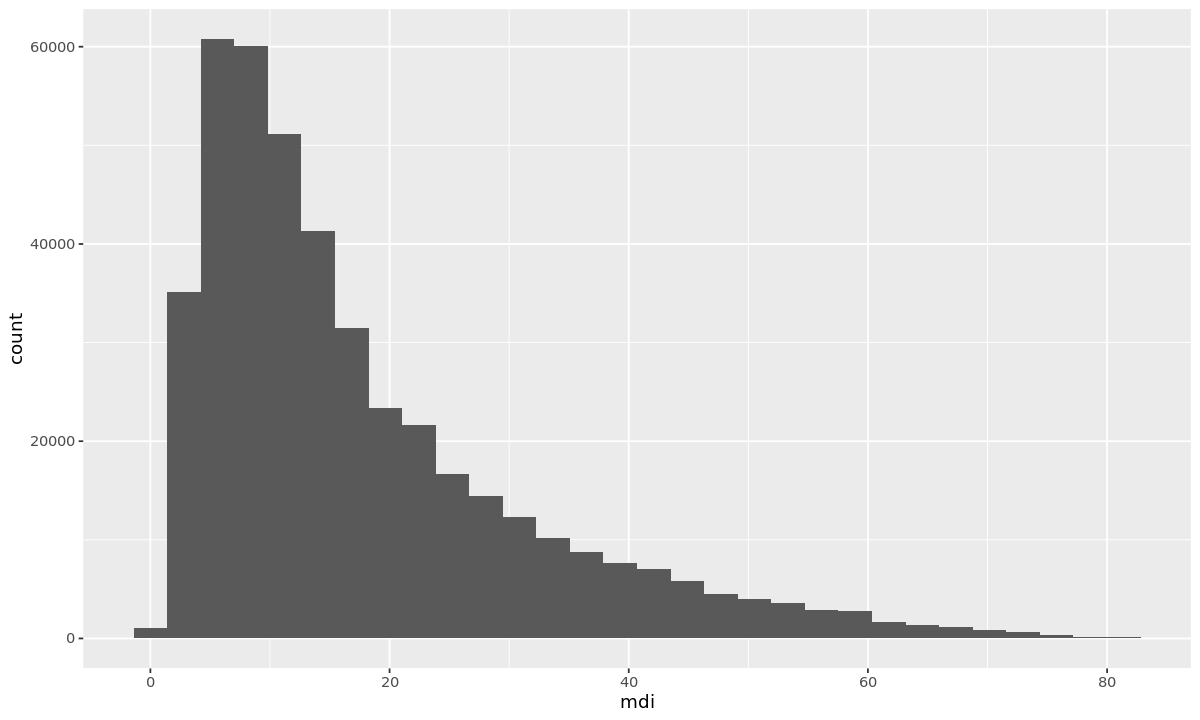

In [15]:
sdh_df %>%
  ggplot(aes(x=mdi)) +
  geom_histogram()

## Other phenotypes

* Read in various phenotype files
* Create ancestry-specific files with criteria:
    - Unrelated
    - Passing QC
    - Consent not withdrawn
* Final output of this section has all exposures and covariates

In [16]:
system(paste0("gsutil cp ", ws_bucket, "/phenotypes/UKB*genoQC* ."))
afr_df <- fread("UKB_genoQC_AFR_N7447_geneticPCs_genoarray", data.table = F, stringsAsFactors = F)
eas_df <- fread("UKB_genoQC_EAS_N2264_geneticPCs_genoarray", data.table = F, stringsAsFactors = F)
eur_df <- fread("UKBiobank_genoQC_reportedANDgeneticEUR_N455146_FLOREZ_EUR_PCA_covariates_40dim.txt", data.table = F, stringsAsFactors = F)
sas_df <- fread("UKB_genoQC_SAS_N8669_geneticPCs_genoarray", data.table = F, stringsAsFactors = F)

system(paste0("gsutil cp ", ws_bucket, "/phenotypes/w27892* ."))
withdrawn_consent <- scan("w27892_20210201.csv")

In [17]:
sample_df <- bind_rows(list(
  AFR = afr_df,
  EAS = eas_df,
  EUR = eur_df,
  SAS = sas_df
), .id="ancestry") %>%
  mutate(array = ifelse(ancestry == "EUR", genotyping.array, cov_GENO_ARRAY)) %>%
  filter(!(Florez_IID %in% withdrawn_consent),
         unrelateds == 1) %>%
  select(id=Florez_IID, ancestry, paste0("PC", 1:10), array)

In [18]:
exp_and_cov_df <- fread("UKBiobank_ALLethnicities_diabetes_complete_2020Feb.txt") %>%
  mutate(sexMale = as.integer(f.31.0.0 == "Male")) %>%
  select(id=f.eid, sexMale, age=f.21022.0.0,
         bmi=f.21001.0.0, t2d=prob_poss_t2dm_all)

In [40]:
system(paste0("gsutil cp ", ws_bucket, "/phenotypes/ukb10528.tab.gz ."))
gPC_df <- fread("ukb10528.tab.gz", stringsAsFactors=FALSE,
                select=c("f.eid", paste0("f.22009.0.", 1:10))) %>%
    dplyr::rename(id=f.eid, 
                  gPC1=f.22009.0.1, gPC2=f.22009.0.2, gPC3=f.22009.0.3, gPC4=f.22009.0.4, gPC5=f.22009.0.5,
                  gPC6=f.22009.0.6, gPC7=f.22009.0.7, gPC8=f.22009.0.8, gPC9=f.22009.0.9, gPC10=f.22009.0.10)

In [41]:
pheno_df <- sample_df %>%
  inner_join(exp_and_cov_df, by="id") %>%
  left_join(gPC_df, by="id") %>%
  left_join(sdh_df, by="id")


   AFR    EAS    EUR    SAS 
  6806   2173 378051   7895 


     0      1 
212935 181990 


     0      1 
376056  18869 

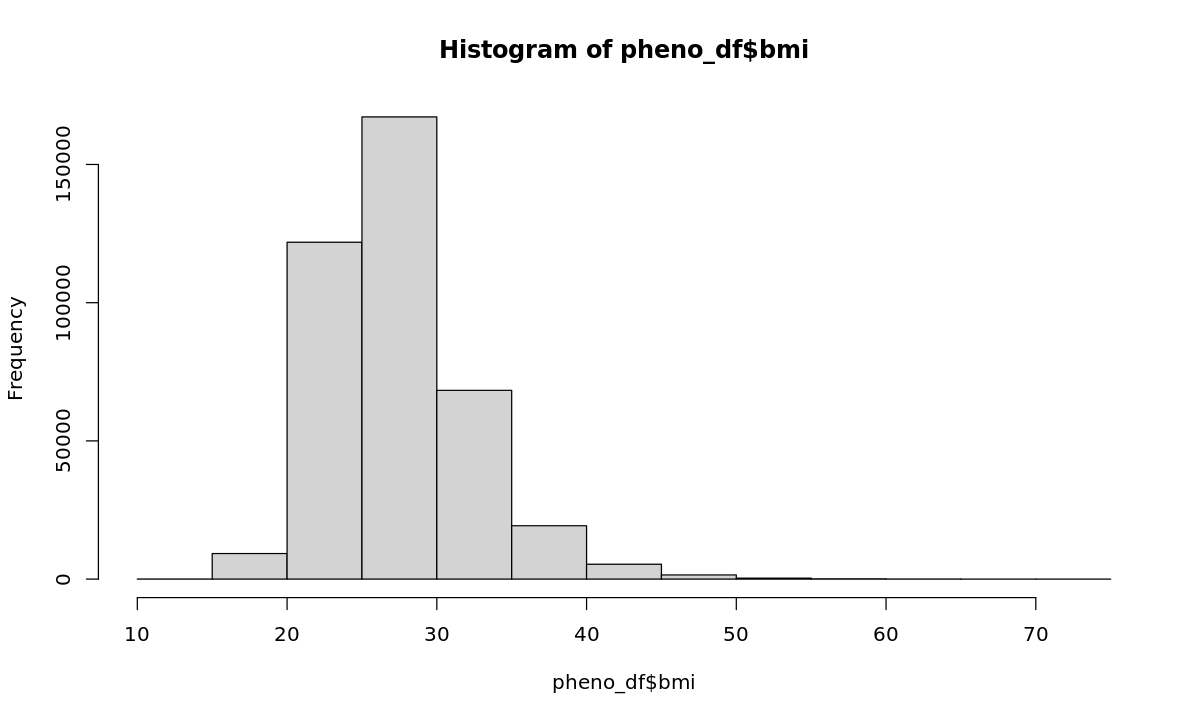

In [42]:
table(pheno_df$ancestry)
table(pheno_df$sex)
hist(pheno_df$bmi)
table(pheno_df$t2d)

## Merge datasets and write to file

In [44]:
# Join covariates + exposures data frame with Covid data frame
final_pheno_df <- pheno_df %>%
  left_join(covid_df, by="id") %>%
  replace_na(list(case_b2=0))

In [45]:
dim(final_pheno_df)
names(final_pheno_df)
with(final_pheno_df, table(ancestry, case_b2))

[1] 394925     29

[1] "id"       "ancestry" "PC1"      "PC2"      "PC3"      "PC4"     
 [7] "PC5"      "PC6"      "PC7"      "PC8"      "PC9"      "PC10"    
[13] "array"    "sexMale"  "age"      "bmi"      "t2d"      "gPC1"    
[19] "gPC2"     "gPC3"     "gPC4"     "gPC5"     "gPC6"     "gPC7"    
[25] "gPC8"     "gPC9"     "gPC10"    "mdi"      "case_b2"

        case_b2
ancestry      0      1
     AFR   6713     93
     EAS   2151     22
     EUR 375649   2402
     SAS   7773    122

In [3]:
# Finally, write pooled and ancestry-specific phenotype files
final_pheno_df$ancestryEUR <- as.integer(final_pheno_df$ancestry == "EUR")
final_pheno_df$ancestryEAS <- as.integer(final_pheno_df$ancestry == "EAS")
final_pheno_df$ancestrySAS <- as.integer(final_pheno_df$ancestry == "SAS")
write_csv(final_pheno_df, "covid_interaction_phenotypes_pooled.csv")
system(paste0("gsutil cp covid_interaction_phenotypes_pooled.csv ", ws_bucket, "/phenotypes/"))
for (anc in unique(final_pheno_df$ancestry)) {
    write_csv(filter(final_pheno_df, ancestry == anc),
              paste0("covid_interaction_phenotypes_", anc, ".csv"))
    system(paste0("gsutil cp covid_interaction_phenotypes_", anc, ".csv ", ws_bucket, "/phenotypes/"))
}

Below, we will define a new "case_b2_ds" phenotype that has the same set of cases as the main phenotype, but a large portion of the controls set to missing so the case-control imbalance is not as extreme (in this case, aiming to achieve a ratio of 1:10).

In [25]:
final_pheno_df <- read_csv("covid_interaction_phenotypes_pooled.csv")

#Create a second phenotype with randomly-downsampled controls for testing
set.seed(1)
final_pheno_df$case_b2_ds <- as.integer(NA)
final_pheno_df$case_b2_ds[final_pheno_df$case_b2 == 1] <- 1
final_pheno_df$case_b2_ds[sample(which(final_pheno_df$case_b2 == 0), size=80000)] <- 0
with(final_pheno_df, table(ancestry, case_b2_ds), useNA="always")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  ancestry = col_character(),
  array = col_character()
)
ℹ Use `spec()` for the full column specifications.




        case_b2_ds
ancestry     0     1
     AFR  1394    41
     EAS   442    10
     EUR 76541   702
     SAS  1623    45

## Check on exposure-phenotype associations

### Basic set of exposures (across all three analyses)

In [55]:
# European-specific (with EUR-specific PCs)
lm_covs <- c("age", paste0("PC", 1:10))
full_lm_str <- paste0("case_b2 ~ sexMale + bmi + t2d + mdi + ", paste(lm_covs, collapse=" + "))
print(full_lm_str)
full_lm <- glm(as.formula(full_lm_str), data=filter(final_pheno_df, ancestry == "EUR"), family="binomial")
broom::tidy(full_lm)

[1] "case_b2 ~ sexMale + bmi + t2d + mdi + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-8.73171008,0.216400679,-40.34973518,0.000000e+00
sexMale,0.32830778,0.045617100,7.19703309,6.153683e-13
bmi,0.05782708,0.004152679,13.92524892,4.449885e-44
t2d,0.46354973,0.076851218,6.03178118,1.621623e-09
mdi,0.01924839,0.001368981,14.06038112,6.652697e-45
age,0.02505544,0.002986312,8.39009305,4.857576e-17
PC1,-5.62316390,1.484694575,-3.78742133,1.522189e-04
PC2,3.01262431,1.698318031,1.77388702,7.608184e-02
PC3,-3.35010311,2.172301069,-1.54219098,1.230272e-01


In [57]:
# Pooled
lm_covs <- c("age", paste0("gPC", 1:10), "ancestry * sexMale", "ancestry * bmi", "ancestry * t2d", "ancestry * mdi")
full_lm_str <- paste0("case_b2 ~ sexMale + bmi + t2d + mdi + ", paste(lm_covs, collapse=" + "))
full_lm <- glm(as.formula(full_lm_str), data=final_pheno_df, family="binomial")
broom::tidy(full_lm)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.6904414192,1.127575115,-6.8203362,9.082767e-12
sexMale,0.5511113189,0.228987690,2.4067290,1.609611e-02
bmi,0.0717262081,0.017543218,4.0885434,4.340903e-05
t2d,0.3903771008,0.280684487,1.3908040,1.642849e-01
mdi,0.0049783530,0.006998023,0.7113942,4.768400e-01
age,0.0235032717,0.002815682,8.3472762,6.985524e-17
gPC1,0.0007551386,0.002702230,0.2794502,7.798994e-01
gPC2,-0.0127969574,0.005639888,-2.2690089,2.326778e-02
gPC3,-0.0088128504,0.007550119,-1.1672466,2.431108e-01
